In [55]:
import numpy as np
import pandas as pd
from itertools import *
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spst
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

import os

import warnings # 경고메세지 무시
warnings.simplefilter(action='ignore', category=FutureWarning)

In [173]:
print(pd)

<module 'pandas' from 'e:\\anaconda3\\lib\\site-packages\\pandas\\__init__.py'>


In [21]:
# 폴더 생성 함수

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [22]:
data = pd.read_csv('titanic.csv')
display(data.head(), data.shape)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 12)

In [23]:
# NaN 개수 파악 df

def checkNAN(df):

    train_nan = list(df.isna().sum())
    num_nan = list(filter(lambda x:x >= 1, train_nan)) # nan값이 1개 이상인 친구만 보여줌

    index_nan = list(filter(lambda e:train_nan[e] >= 1, range(len(train_nan)))) # 이건 인덱스

    nan_df = pd.DataFrame({'index_in_train' : index_nan, 'column_name' : df.iloc[:, index_nan].columns, 'NAN_number' : num_nan})
    
    return nan_df

In [24]:
# 간단한 결측치 처리 자동화 코드

def handle_NAN(df, list_lists, fill_na, fill_value, back_fill, front_fill, linear, KNN):
    
    imputer = KNNImputer(n_neighbors = KNN[1])

    fill_val_dict = {}
    if fill_value[0] != -1:
        for i in range(len(fill_value[1])):
            fill_val_dict[list_lists[fill_value[0]][i]] = fill_value[1][i]
        
    sequence = {fill_na[0] : "df[" + str(list_lists[fill_na[0]]) + "].fillna(" + str(fill_na[1]) + ")", 
                fill_value[0] : "df[" + str(list_lists[fill_value[0]]) + "].fillna(" + str(fill_val_dict) + ")", 
                back_fill : "df[" + str(list_lists[back_fill]) + "].fillna( method='bfill' )",
                front_fill : "df[" + str(list_lists[front_fill]) + "].fillna( method='ffill' )",
                linear : "df[" + str(list_lists[linear]) + "].interpolate(method='linear')",
                KNN[0] : "imputer.fit_transform(df[" + str(list_lists[KNN[0]]) + "])",
                }
    
    del sequence[-1]

    sequence_sort = dict(sorted(sequence.items()))

    for n in range(len(sequence_sort)):
        if "KNN" in sequence_sort[n]:
            df[list_lists[KNN[0]]]=pd.DataFrame(eval(sequence_sort[n]), columns=list_lists[KNN[0]])
        else:
            df[list_lists[n]] = eval(sequence_sort[n])
    return df

In [25]:
# 간단한 결측치 자동 처리기 미리보기

##########################################################################################
# 아래의 숫자는 파라미터입니다. 0부터 코드가 시작되며 결측치가 처리됩니다.
# fill_na의 [0]은 순서, [1]은 채워지는 값입니다.
# fill_value의 [0]은 순서, [1]은 정해주는 컬럼마다 채워지는 값입니다. ex) ['Age'. 'Fare'], [1, 2]이면 // Age는 1, Fare은 2로 채워짐
# col_list에는 리스트 형태로 컬럼명을 넣어주면 됩니다. 주의 : 이중 리스트가 아님!
##########################################################################################

col_list = [['Embarked'], ['Cabin'], ['Age', 'Fare']]
fill_na = [0, 3]
fill_value = [-1, [0]]
back_fill = -1
front_fill = 1
linear = -1
KNN = [2, 5]

def NAN_preview(data, col_list, fill_na, fill_value, back_fill, front_fill, linear, KNN):
    nan_df = checkNAN(data)
    display(nan_df)
    print('=='*20)

    sequence_view = [data, col_list, fill_na, fill_value, back_fill, front_fill]
    sequence_num = sequence_view[2 : len(sequence_view)]

    sequence_dic = pd.DataFrame({'func' : [fill_na[0], fill_value[0], back_fill, front_fill, linear, KNN[0]], 
                                'func_list' : ['fill_na', 'fill_value', 'backfill', 'front_fill', 'linear', 'KNN'], 
                                'parameter' : [fill_na[1], fill_value[1], 'none', 'none', 'none', KNN[1]]})
    sequence_dic = sequence_dic.sort_values('func')


    display(sequence_dic)

    sequence_dic = sequence_dic[sequence_dic['func'] >= 0]
    sequence_dic['columns'] = col_list
    print('=='*20)
    display(sequence_dic)

,index_in_train,column_name,NAN_number
0,5,Age,177
1,10,Cabin,687
2,11,Embarked,2


,func,func_list,parameter
1,-1,fill_value,[0]
2,-1,backfill,none
4,-1,linear,none
0,0,fill_na,3
3,1,front_fill,none
5,2,KNN,5


,func,func_list,parameter,columns
0,0,fill_na,3,[Embarked]
3,1,front_fill,none,[Cabin]
5,2,KNN,5,"[Age, Fare]"


In [28]:
col_list = [['Embarked', 'Cabin'], ['Age', 'Fare']]
fill_na = [-1, 3]
fill_value = [0, ['S', 'S']]
back_fill = -1
front_fill = -1
linear = -1
KNN = [1, 5]

a = handle_NAN(data, col_list, fill_na, fill_value, back_fill, front_fill, linear, KNN)
display(a)
display(checkNAN(data))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,S,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


,index_in_train,column_name,NAN_number


In [8]:
# 변수들
def check_features(data):

    cat = list(set(list(data.select_dtypes("object").columns) + list(data.select_dtypes("bool").columns) + list(data.select_dtypes("category").columns)))
    num = list(set(list(data.select_dtypes("int").columns) + list(data.select_dtypes("float").columns)))
    # include_word_feats1 = [s for s in data if "변수에 포함된 단어" in s]
    # include_word_feats2 = [s for s in data if "변수에 포함된 단어" in s]
    print(cat)
    print(num)
    
    return cat, num

In [9]:
# 컬럼 타입 변경

# data.astype({'컬럼명':'float', '컬럼명':'float'}).dtypes

In [10]:
# 상관계수 히트맵
def make_corr_heatmap(df):
    
    plt.figure(figsize = (8, 8))
    mask = np.zeros_like(df.corr(), dtype=bool) # corr을 다른 것으로 바꾸면 다른 상관계수 그래프를 그릴 수도 있음
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(df.corr(), annot = True, fmt = '.3f', mask = mask, cmap = 'RdYlBu_r',  vmin = -1, vmax = 1)
    plt.show()

In [11]:
# distplot 자동 생성기

def make_distplots(feature_list):

    dist_feature_list = feature_list

    createFolder('distplot')

    rcm = 1

    while True:
        if len(dist_feature_list) <= rcm ** 2:
            break
        else:
            rcm += 1

    count_index = 1

    for i in dist_feature_list:
        plt.subplot(rcm, rcm, count_index)
        
        sns.distplot(data[i], hist = True, bins = 16)

        plt.title(i)
        plt.tight_layout()
        plt.savefig('distplot\\dist')
            
        count_index += 1
    plt.show()

In [12]:
# 모든 scatter plot과 histogram plot을 그려주는 명령어, 렉걸릴 수 있으니 조심해서 사용

# sns.pairplot(data, hue = 'Survived')
# plt.show()

In [13]:
# boxplot 자동 생성기

def make_boxplots(feature_list):

    dist_feature_list = feature_list

    createFolder('boxplot')

    rcm = 1

    while True:
        if len(dist_feature_list) <= rcm ** 2:
            break
        else:
            rcm += 1

    count_index = 1

    for i in dist_feature_list:
        plt.subplot(rcm, rcm, count_index)
        
        sns.boxplot(data = data, x = data[i])

        plt.title(i)
        plt.tight_layout()
        plt.savefig('boxplot\\box')
            
        count_index += 1
    plt.show()

In [14]:
# p-value df 생성 코드, (p-value는 보통 0.05 이하이면 신뢰성이 있다고 본다, 0.05이하라는건 신뢰도가 95% 이상이라는 것)

def make_pvalue_df(feature_list, p_value_v, target):
    printList = list(combinations(feature_list, 2))

    name1 = []
    name2 = []
    corr = []
    pval = []

    if target == 0:
        for i in printList:
            test1 = spst.pearsonr(data[i[0]], data[i[1]])
            name1.append(i[0])
            name2.append(i[1])
            corr.append(float(format(test1[0], '.6f')))
            pval.append(float(format(test1[1], '.6f')))
    else:
        for n in feature_list:
            test2 = spst.pearsonr(data[n], data[target])
            name1.append(n)
            name2.append(target)
            corr.append(float(format(test2[0], '.6f')))
            pval.append(float(format(test2[1], '.6f')))
    pval_df = pd.DataFrame({'name1' : name1, 'name2' : name2, 'corr' : corr, 'p-value' : pval})
    pval_df = pval_df.loc[pval_df['p-value'] <= p_value_v]
    pval_df = pval_df.sort_values('corr')
            
    return pval_df

In [15]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,C85,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,C123,S


In [16]:
# 회색줄 = 신뢰구간이 서로 안겹칠수록 둘사이의 연관이 큼, ex) sc는 훌륭함, cq는 그냥 그럼

def make_barplots(feature_list, target):

    dist_feature_list = feature_list

    createFolder('barplot')

    rcm = 1

    while True:
        if len(dist_feature_list) <= rcm ** 2:
            break
        else:
            rcm += 1

    count_index = 1

    for i in dist_feature_list:
        plt.subplot(rcm, rcm, count_index)
        
        sns.barplot(x = i, y = target, data = data)

        plt.title(i)
        plt.tight_layout()
        plt.savefig('barplot\\bar')
            
        count_index += 1
    plt.show()

['Embarked', 'Name', 'Cabin', 'Ticket', 'Sex']
['Pclass', 'Survived', 'Parch', 'Age', 'SibSp', 'Fare', 'PassengerId']


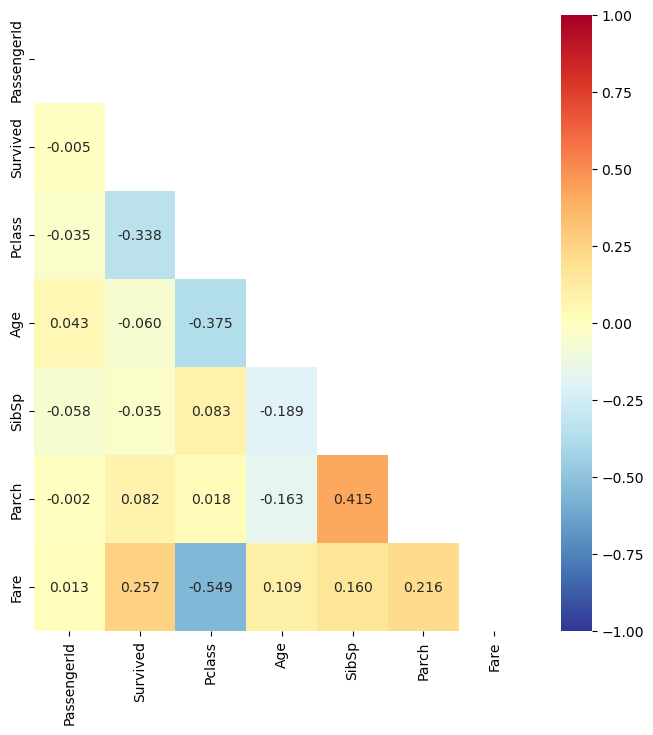

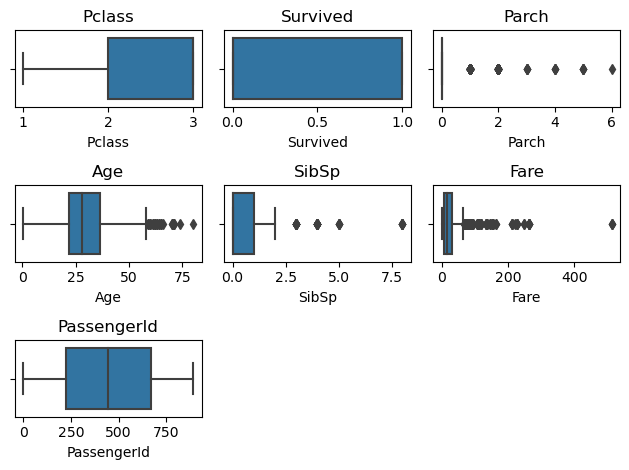

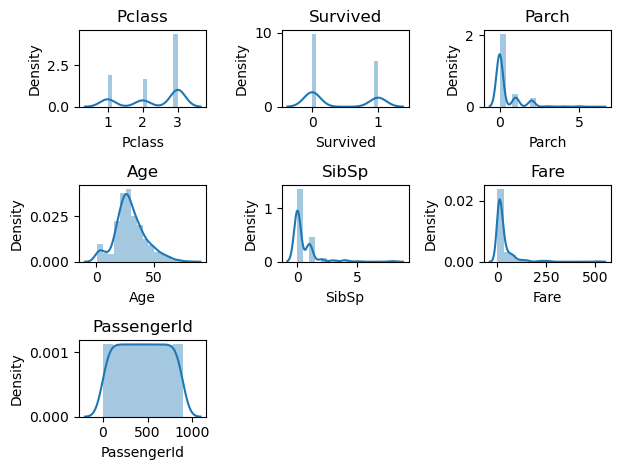

,name1,name2,corr,p-value
0,Pclass,Survived,-0.338481,0.000000
2,Parch,Survived,0.081629,0.014799
5,Fare,Survived,0.257307,0.000000
1,Survived,Survived,1.000000,0.000000


In [17]:
categorial_feats, numerical_feats = check_features(data)
checkNAN(data)
make_corr_heatmap(data)
make_boxplots(numerical_feats)
make_distplots(numerical_feats)
pv_df = make_pvalue_df(numerical_feats, 0.05, 'Survived')
display(pv_df)

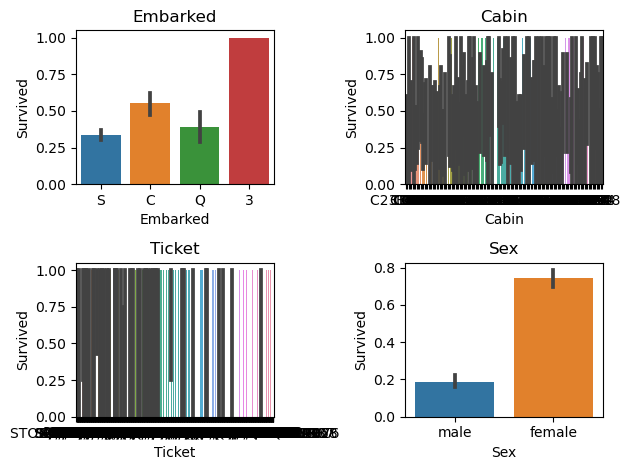

In [19]:
make_barplots(['Embarked', 'Cabin', 'Ticket', 'Sex'], 'Survived')

In [33]:
died = data.loc[data['Survived'] == 0, 'Age']
survived = data.loc[data['Survived'] == 1, 'Age']
spst.ttest_ind(died, survived)

Ttest_indResult(statistic=1.7919220148061457, pvalue=0.07348544674745884)

In [36]:
data['Survived'].unique()[0]

0

In [169]:
def make_ttest_df(data, nume, p_value_v, cat):
    
    if cat in nume:
        nume.remove(cat)
    
    name1 = []
    name2 = []
    corr = []
    pval = []

    for n in nume:
        tt1 = data.loc[data[cat] == data[cat].unique()[0], n]
        tt2 = data.loc[data[cat] == data[cat].unique()[1], n]
        test2 = spst.ttest_ind(tt1, tt2)
        name1.append(n)
        name2.append(cat)
        corr.append(float(format(test2[0], '.6f')))
        pval.append(float(format(test2[1], '.6f')))
        
    ttest_df = pd.DataFrame({'name1' : name1, 'name2' : name2, 'statistic' : corr, 'p-value' : pval})
    ttest_df = ttest_df.loc[ttest_df['p-value'] <= p_value_v]
    ttest_df = ttest_df.sort_values('statistic')

    return ttest_df

In [170]:
make_ttest_df(numerical_feats, 0.05, 'Survived')

,name1,name2,statistic,p-value
4,Fare,Survived,-7.939192,0.000000
1,Parch,Survived,-2.442020,0.014799
0,Pclass,Survived,10.725263,0.000000


In [51]:
P_1 = data.loc[data.Pclass == 1, 'Age']
P_2 = data.loc[data.Pclass == 2, 'Age']
P_3 = data.loc[data.Pclass == 3, 'Age']

spst.f_oneway(P_1, P_2, P_3)

F_onewayResult(statistic=74.04997836982706, pvalue=1.8072645617668764e-30)

In [84]:
list_str = str(list)[1:-1]
print(list_str)

class 'list'


In [129]:
list(data['Pclass'].unique())

[3, 1, 2]

In [115]:
x = "an0"
for od in range(1, len(data['Pclass'].unique())):
    x = x + ", an" + str(od)
print(x)

an0, an1, an2


In [171]:
def make_ANOVA_df(nume, p_value_v, cat):
    
    if cat in nume:
        nume.remove(cat)
    
    name1 = []
    name2 = []
    x = []
    anova = []
    pval = []

    for n in nume:
        for asd in cat:
            count = 0
            for a in range(data[asd].nunique()):
                globals()["an{}".format(count)] = data.loc[data[asd] == list(data[asd].unique())[count], n]
                count += 1
            x = "an0"
            for od in range(1, len(data[asd].unique())):
                x = x + ", an" + str(od)
            x1 = "spst.f_oneway(" + x + ")"
            test2 = eval(x1)
            name1.append(n)
            name2.append(asd)
            anova.append(float(format(test2[0], '.6f')))
            pval.append(float(format(test2[1], '.6f')))
        
    anova_df = pd.DataFrame({'name1' : name1, 'name2' : name2, 'anova-statistic' : anova, 'p-value' : pval})
    anova_df = anova_df.loc[anova_df['p-value'] <= p_value_v]
    anova_df = anova_df.sort_values('anova-statistic')

    return anova_df

In [172]:
make_ANOVA_df(['Age', 'Fare'], 0.05, ['Pclass', 'Embarked'])

,name1,name2,anova-statistic,p-value
3,Fare,Embarked,37.900719,0.0
0,Age,Pclass,74.049978,0.0
2,Fare,Pclass,242.344157,0.0
